In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots an event-level variable (in this case, MET, but switching it is as easy as a dict-key change).
# It also demonstrates an easy use of the book-keeping cutflow tool, to keep track of the number of events processed.

# The processor class bundles our data analysis together while giving us some helpful tools. 
# It also leaves looping and chunks to the framework instead of us.
class METProcessor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. 
        # For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET", "MET [GeV]", 50, 0, 100)
        
        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        # This is where we do our actual analysis. The df has dict keys equivalent to the TTree's.
        dataset = df['dataset']
        MET = df['MET_pt']
        
        # We can define a new key for cutflow (in this case 'all events'). Then we can put values into it. 
        # We need += because it's per-chunk (demonstrated below)
        output['cutflow']['all events'] += MET.size
        output['cutflow']['number of chunks'] += 1
        
        # This fills our histogram once our data is collected. Always use .flatten() to make sure the array is reduced.
        # The output key will be as defined in __init__ for self._accumulator; the hist key ('MET=') will be defined in the bin.
        output['MET'].fill(dataset=dataset, MET=MET.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'MET': ["data/Run2012B_SingleMu.root"]}

output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=METProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 500000)

Processing: 100%|██████████| 107/107 [00:09<00:00, 11.84items/s]


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (MET) instance at 0x7f0c4153f470>: [<matplotlib.collections.PolyCollection at 0x7f0bdd7d97b8>],
  'legend': <matplotlib.legend.Legend at 0x7f0bdd7d9518>})

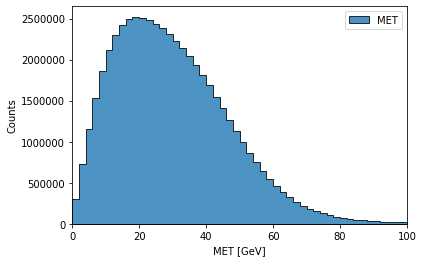

In [4]:
# Generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional, to fill the graph (default is a line).
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
# Easy way to print all cutflow dict values. Can just do print(output['cutflow']["KEY_NAME"]) for one.
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of chunks 107
